<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/3_5_15_LangGraph_2_Self_Corrective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph 실습 2: Self-Corrective 검색 (루프)
Self-Corrective 검색 (루프): Corrective-RAG (CRAG) 단순화버전

- LangGraph의 핵심 기능인 **루프(Loop)**를 구현한다
- "결과가 안 좋으면 다시 시도"하는 Self-Corrective 패턴을 이해한다
- 무한 루프 방지를 위한 종료 조건 설계를 학습한다

---

## 핵심: 왜 루프가 필요한가?

**LangChain (Chain)**: 직선 흐름만 가능
```
입력 → 검색 → 답변 생성 → 출력 (끝!)
```

**LangGraph (Agent)**: 되돌아가기 가능
```
입력 → 검색 → 평가 → (안좋으면) → 다시 검색! ← 루프
                    → (좋으면) → 답변 생성 → 출력
```

실제 RAG 시스템에서 **첫 번째 검색이 항상 좋은 결과를 주지 않습니다.**  
LangGraph를 쓰면 "검색 결과가 별로면 쿼리를 바꿔서 다시 검색"하는 로직을 구현할 수 있습니다.

| 구분                 | CRAG (Corrective-RAG)     | Self-Corrective 검색 (단순화 버전) |
| ------------------ | ---------------------------- | --------------------------- |
| 기본 목적              | 왜 틀렸는지 분석하고 **적절한 교정 전략** 선택 | 답이 부족하면 **다시 검색**           |
| 품질 평가 단계 (Critic)  | ✅ 별도 평가 로직 존재                | ❌ 없음 (LLM 단순 판단)            |
| 오류 원인 분석           | ✅ 검색 실패 / 질문 오해 / 추론 문제 분리   | ❌ 모두 “검색 부족”으로 간주           |
| 교정 전략 예시           | 쿼리 재작성, retriever 변경, 문서 필터링 | 재검색(쿼리 재작성)만 수행                     |
| Query Rewriting    | ✅ 있음                         | ❌ 거의 없음                     |
| 루프 종료 조건           | 품질 임계값, 반복 제한 등 정교           | 단순 boolean 또는 1~2회 반복       |
| 구조 복잡도             | 높음 (프로덕션 지향)                 | 낮음 (교육·실습 지향)              


## 0. 환경 설정

In [ ]:
# 패키지 설치
!pip install -q langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 14.5 MB/s eta 0:00:00


In [ ]:
# API 키 설정
import os
from getpass import getpass

# API 키 설정
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

OpenAI API Key: ··········


## 1. 시나리오: Self-Corrective RAG 시뮬레이션

```
     ┌─────────────────────────────┐
     │                             │
     ▼                             │ (재시도)
 [search] → [evaluate] ───────────┘
                 │
                 │ (통과)
                 ▼
           [generate]
                 │
                 ▼
               종료
```

- `search`: 검색 수행 (시뮬레이션: 3번째에 좋은 결과)
- `evaluate`: 결과 품질 평가
- 평가 통과 시 → `generate`로 이동
- 평가 실패 시 → `search`로 **되돌아감** (루프!)

## 2. 코드 구현

In [ ]:
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
# ============================================
# [1] State 정의
# ============================================

class SearchState(TypedDict):
    query: str              # 원본 검색 쿼리
    current_query: str      # 현재 사용 중인 쿼리 (재작성될 수 있음)
    search_result: str      # 검색 결과
    is_relevant: bool       # 검색 결과가 관련 있는지
    attempts: int           # 검색 시도 횟수
    final_answer: str       # 최종 답변

In [ ]:
# ============================================
# [2] Node 정의
# ============================================

# 시뮬레이션용 가짜 검색 결과
FAKE_SEARCH_RESULTS = {
    1: "LangGraph는... (관련 없는 광고 내용)",
    2: "그래프 이론의 역사... (관련 없는 학술 내용)",
    3: "LangGraph는 LangChain 위에 구축된 라이브러리로, 상태 기반의 순환 그래프를 통해 복잡한 AI 에이전트를 구현할 수 있습니다.",
    4: "LangGraph는 상태(State), 노드(Node), 엣지(Edge)로 구성되며, 조건부 분기와 루프를 지원합니다.",
}

In [ ]:
# 검색 노드
def search(state: SearchState) -> dict:
    """검색 노드 (시뮬레이션)"""
    attempts = state.get("attempts", 0) + 1
    current_query = state.get("current_query", state["query"])

    print(f"\n[search] 검색 시도 #{attempts}")
    print(f"   쿼리: '{current_query}'")

    # 시뮬레이션: attempts에 따라 다른 결과 반환
    result = FAKE_SEARCH_RESULTS.get(attempts, FAKE_SEARCH_RESULTS[4])
    print(f"   결과: {result[:50]}...")

    return {
        "search_result": result,
        "attempts": attempts
    }

In [ ]:
# 검색 결과 품질 평가 노드
def evaluate(state: SearchState) -> dict:
    """검색 결과 품질 평가 노드"""
    print(f"\n[evaluate] 결과 평가 중...")

    # LLM으로 관련성 평가
    evaluation_prompt = f"""
    사용자 질문: {state['query']}
    검색 결과: {state['search_result']}

    위 검색 결과가 사용자 질문에 답하기에 충분히 관련 있나요?
    'yes' 또는 'no'로만 답해주세요.
    """

    response = llm.invoke(evaluation_prompt)
    is_relevant = "yes" in response.content.lower()

    print(f"   평가 결과: {'✅ 관련 있음' if is_relevant else '❌ 관련 없음'}")

    return {"is_relevant": is_relevant}

In [ ]:
# 검색 쿼리 재작성 노드
def rewrite_query(state: SearchState) -> dict:
    """검색 쿼리 재작성 노드"""
    print(f"\n[rewrite_query] 쿼리 재작성 중...")

    rewrite_prompt = f"""
    원본 질문: {state['query']}
    이전 쿼리: {state['current_query']}
    검색 결과가 관련 없었습니다.

    더 좋은 검색 결과를 얻기 위해 쿼리를 재작성해주세요.
    재작성된 쿼리만 출력해주세요.
    """

    response = llm.invoke(rewrite_prompt)
    new_query = response.content.strip()

    print(f"   새 쿼리: '{new_query}'")

    return {"current_query": new_query}

In [ ]:
# 최종 답변 생성 노드
def generate(state: SearchState) -> dict:
    """최종 답변 생성 노드"""
    print(f"\n[generate] 답변 생성 중...")

    generate_prompt = f"""
    질문: {state['query']}
    참고 자료: {state['search_result']}

    위 자료를 바탕으로 질문에 답변해주세요.
    """

    response = llm.invoke(generate_prompt)

    return {"final_answer": response.content}

In [ ]:
# ============================================
# [3] Router 정의: 루프 여부 결정
# ============================================

def should_continue(state: SearchState) -> Literal["rewrite_query", "generate"]:
    """
    평가 결과에 따라 루프 여부 결정
    - 관련 있음 OR 최대 시도 횟수 도달 → generate로 이동
    - 관련 없음 AND 시도 가능 → rewrite_query로 이동 (루프!)
    """
    MAX_ATTEMPTS = 5

    print(f"\n[Router] 판단 중...")
    print(f"   is_relevant={state['is_relevant']}, attempts={state['attempts']}")

    if state["is_relevant"]:
        print("   → generate로 이동 (평가 통과)")
        return "generate"

    if state["attempts"] >= MAX_ATTEMPTS:
        print(f"   → generate로 이동 (최대 시도 {MAX_ATTEMPTS}회 도달)")
        return "generate"

    print("   → rewrite_query로 이동 (재시도)")
    return "rewrite_query"  # 👈 루프!

In [ ]:
# ============================================
# [4] 그래프 조립
# ============================================

workflow = StateGraph(SearchState)

# 노드 등록
workflow.add_node("search", search)
workflow.add_node("evaluate", evaluate)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate", generate)

# 엣지 연결
workflow.add_edge(START, "search")
workflow.add_edge("search", "evaluate")

# !!! 핵심: 조건부 엣지로 루프 구현 !!!
workflow.add_conditional_edges(
    source="evaluate",
    path=should_continue,
    path_map={
        "rewrite_query": "rewrite_query",   # 루프 경로
        "generate": "generate"              # 탈출 경로
    }
)

# rewrite_query → search 로 되돌아감 (루프 완성!)
workflow.add_edge("rewrite_query", "search")

workflow.add_edge("generate", END)

# 컴파일: 그래프 설계를 확정(compile)하여 invoke 가능한 상태로 만듦
app = workflow.compile()

print("그래프 컴파일 완료!")

그래프 컴파일 완료!


## 3. 그래프 시각화

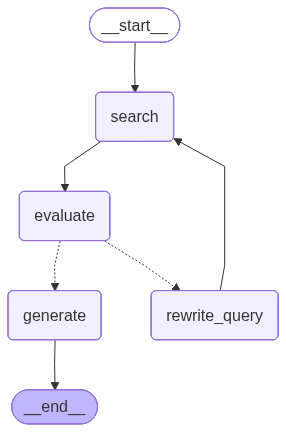

In [ ]:
from IPython.display import Image, display

# 그래프 시각화 - 루프가 보입니다!
display(Image(app.get_graph().draw_mermaid_png()))

## 4. 실행 테스트

In [ ]:
# 실행!
print("=" * 60)
print("Self-Corrective RAG 실행")
print("=" * 60)

result = app.invoke({
    "query": "LangGraph란 무엇인가요?",
    "current_query": "LangGraph란 무엇인가요?",
    "search_result": "",
    "is_relevant": False,
    "attempts": 0,
    "final_answer": ""
})

print("\n" + "=" * 60)
print("----최종 결과")
print("=" * 60)
print(f"총 검색 시도: {result['attempts']}회")
print(f"\n최종 답변:\n{result['final_answer']}")

Self-Corrective RAG 실행

[search] 검색 시도 #1
   쿼리: 'LangGraph란 무엇인가요?'
   결과: LangGraph는... (관련 없는 광고 내용)...

[evaluate] 결과 평가 중...
   평가 결과: ❌ 관련 없음

[Router] 판단 중...
   is_relevant=False, attempts=1
   → rewrite_query로 이동 (재시도)

[rewrite_query] 쿼리 재작성 중...
   새 쿼리: 'LangGraph의 정의와 기능은 무엇인가요?'

[search] 검색 시도 #2
   쿼리: 'LangGraph의 정의와 기능은 무엇인가요?'
   결과: 그래프 이론의 역사... (관련 없는 학술 내용)...

[evaluate] 결과 평가 중...
   평가 결과: ❌ 관련 없음

[Router] 판단 중...
   is_relevant=False, attempts=2
   → rewrite_query로 이동 (재시도)

[rewrite_query] 쿼리 재작성 중...
   새 쿼리: 'LangGraph의 개념과 주요 기능에 대해 설명해 주세요.'

[search] 검색 시도 #3
   쿼리: 'LangGraph의 개념과 주요 기능에 대해 설명해 주세요.'
   결과: LangGraph는 LangChain 위에 구축된 라이브러리로, 상태 기반의 순환 그래프를...

[evaluate] 결과 평가 중...
   평가 결과: ✅ 관련 있음

[Router] 판단 중...
   is_relevant=True, attempts=3
   → generate로 이동 (평가 통과)

[generate] 답변 생성 중...

----최종 결과
총 검색 시도: 3회

최종 답변:
LangGraph는 LangChain 위에 구축된 라이브러리로, 상태 기반의 순환 그래프를 활용하여 복잡한 AI 에이전트를 구현할 수 있는 도구입니다. 이를 통해 다양한 상태와 전환을 관리하며, AI 에이전트의 행동을 보다 

## 5. 스트리밍으로 루프 과정 추적

In [ ]:
# 각 스텝별 State 변화 추적
print("=" * 60)
print("스트리밍 모드: 각 노드 실행 추적")
print("=" * 60)

step_count = 0
for step in app.stream({
    "query": "LangGraph의 핵심 구성요소는?",
    "current_query": "LangGraph의 핵심 구성요소는?",
    "search_result": "",
    "is_relevant": False,
    "attempts": 0,
    "final_answer": ""
}):
    step_count += 1
    for node_name, node_output in step.items():
        print(f"\n{'─' * 40}")
        print(f"Step {step_count}: 노드 '{node_name}' 완료")
        if "attempts" in node_output:
            print(f"  attempts: {node_output['attempts']}")
        if "is_relevant" in node_output:
            print(f"  is_relevant: {node_output['is_relevant']}")

스트리밍 모드: 각 노드 실행 추적

[search] 검색 시도 #1
   쿼리: 'LangGraph의 핵심 구성요소는?'
   결과: LangGraph는... (관련 없는 광고 내용)...

────────────────────────────────────────
Step 1: 노드 'search' 완료
  attempts: 1

[evaluate] 결과 평가 중...
   평가 결과: ❌ 관련 없음

[Router] 판단 중...
   is_relevant=False, attempts=1
   → rewrite_query로 이동 (재시도)

────────────────────────────────────────
Step 2: 노드 'evaluate' 완료
  is_relevant: False

[rewrite_query] 쿼리 재작성 중...
   새 쿼리: 'LangGraph의 주요 구성 요소는 무엇인가요?'

────────────────────────────────────────
Step 3: 노드 'rewrite_query' 완료

[search] 검색 시도 #2
   쿼리: 'LangGraph의 주요 구성 요소는 무엇인가요?'
   결과: 그래프 이론의 역사... (관련 없는 학술 내용)...

────────────────────────────────────────
Step 4: 노드 'search' 완료
  attempts: 2

[evaluate] 결과 평가 중...
   평가 결과: ❌ 관련 없음

[Router] 판단 중...
   is_relevant=False, attempts=2
   → rewrite_query로 이동 (재시도)

────────────────────────────────────────
Step 5: 노드 'evaluate' 완료
  is_relevant: False

[rewrite_query] 쿼리 재작성 중...
   새 쿼리: 'LangGraph의 주요 구성 요소는 무엇인지 구체적으로 설명해 주세요.'

─

---

## 정리

### 루프 구현의 핵심

```python
# 1. 조건부 엣지에서 이전 노드로 가는 경로 정의
workflow.add_conditional_edges(
    source="evaluate",
    path=should_continue,
    path_map={
        "rewrite_query": "rewrite_query",   # 루프 경로
        "generate": "generate"              # 탈출 경로
    }
)

# 2. 루프 경로가 다시 시작점으로 연결
workflow.add_edge("rewrite_query", "search")  # 👈 여기서 루프!
```

### 무한 루프 방지

```python
MAX_ATTEMPTS = 5
if state["attempts"] >= MAX_ATTEMPTS:
    return "generate"  # 강제 탈출
```

---

## 혼자해보기 실습
### 문제 1: 다중 평가 기준
현재는 "관련성"만 평가합니다. **"정확성"** 평가도 추가해서,  
관련성과 정확성 모두 통과해야 generate로 가도록 수정해보기
